# Carrier Home Challenge
---
This home challenge has been solved by Rohit Nigam on February 16th, 2021. 

---

This notebook is divided in 4 sections
1. Loading and Pre-processing the data
2. Building the Models
3. Conclusion
4. Predicting on the test data set.

---

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from sklearn import metrics

In [116]:
from scipy.stats import boxcox

# 1. Loading and pre processing the data
---


In [117]:
df_results = pd.DataFrame(columns=['Model', 'Train Recall Score', 'Test Recall Score'])

In [118]:
df_train = pd.read_csv('2021-01-21_zeta-disease_training-data_dsi-take-home-challenge.csv')

In [119]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


Good to see there are no nulls in any column!! :-)

In [120]:
df_train.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [121]:
X = df_train.drop('zeta_disease', axis=1)
y = df_train['zeta_disease']

In [122]:
X.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,54,189,27.1,80,0,1.5038,0,10
1,23,150,38.5,68,71,0.3868,55,2
2,47,186,29.9,90,0,0.2728,0,7
3,18,150,30.8,70,1033,0.6598,56,0
4,24,160,32.4,74,125,0.7608,59,2


## 1.1. Checking the Data Imbalance

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='zeta_disease', ylabel='count'>

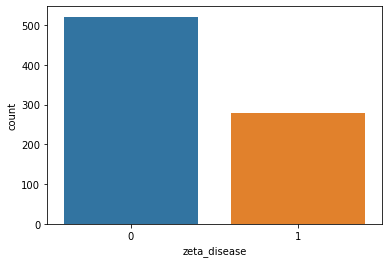

In [123]:
sns.countplot(y)

There is **data imbalance**. While creating the model, it needs to be countered.

---
## 1.2. EDA and Feature Engineering

Let us check the spread of the indicator variables.

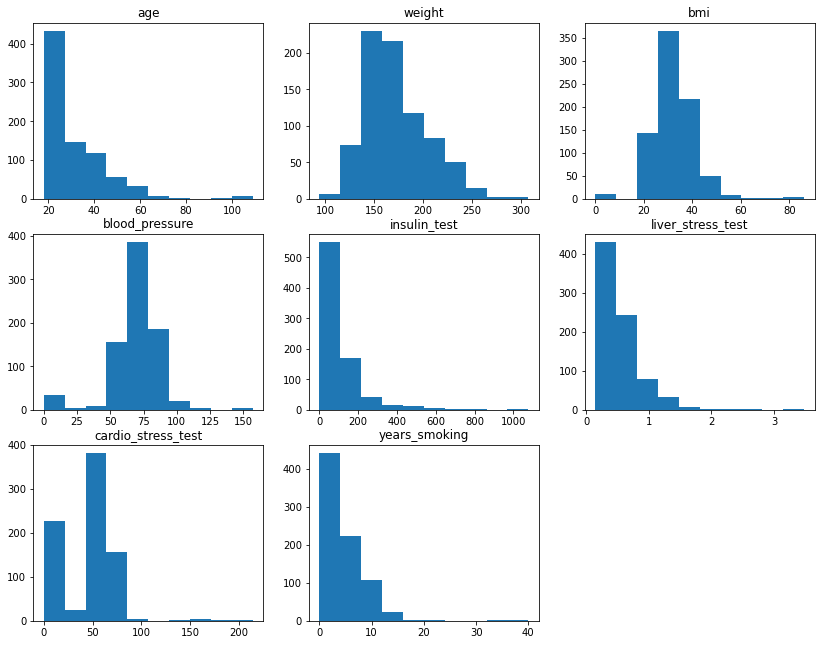

In [124]:
plt.figure(figsize=(14, 11))
for col in X.columns:
    plt.subplot(3, 3, list(X.columns).index(col)+1)
    plt.hist(X[col])
    plt.title(col)
plt.show()

In [125]:
X.loc[X.bmi==0, 'bmi'] = None
X.loc[X.blood_pressure==0, 'blood_pressure'] = None
X.loc[X.insulin_test==0, 'insulin_test'] = None
X.loc[X.cardio_stress_test==0, 'cardio_stress_test'] = None
X.isna().sum()

age                     0
weight                  0
bmi                    11
blood_pressure         35
insulin_test          370
liver_stress_test       0
cardio_stress_test    227
years_smoking           0
dtype: int64

In [126]:
c = np.round(X[['age', 'weight', 'bmi', 
                        'blood_pressure', 'insulin_test', 
                        'cardio_stress_test']].corr(), 2)

In [127]:
c['insulin_test'] # --> cardio stress test

age                   0.08
weight                0.46
bmi                   0.23
blood_pressure        0.04
insulin_test          1.00
cardio_stress_test    0.09
Name: insulin_test, dtype: float64

In [128]:
c['cardio_stress_test'] # --> bmi

age                   0.07
weight                0.18
bmi                   0.36
blood_pressure        0.14
insulin_test          0.09
cardio_stress_test    1.00
Name: cardio_stress_test, dtype: float64

In [129]:
c['blood_pressure'] # -> bmi

age                   0.24
weight                0.15
bmi                   0.22
blood_pressure        1.00
insulin_test          0.04
cardio_stress_test    0.14
Name: blood_pressure, dtype: float64

In [130]:
c['bmi'] # -> weight

age                   0.02
weight                0.21
bmi                   1.00
blood_pressure        0.22
insulin_test          0.23
cardio_stress_test    0.36
Name: bmi, dtype: float64

<AxesSubplot:xlabel='age_cluster', ylabel='age'>

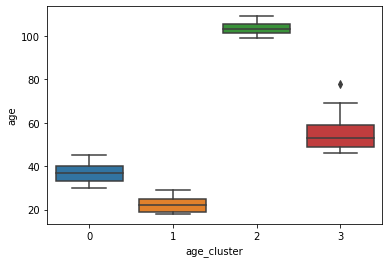

In [131]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4).fit(X[['age']])
X['age_cluster'] = km.labels_
sns.boxplot(y='age', x='age_cluster', data=X)

<AxesSubplot:xlabel='wt_cluster', ylabel='weight'>

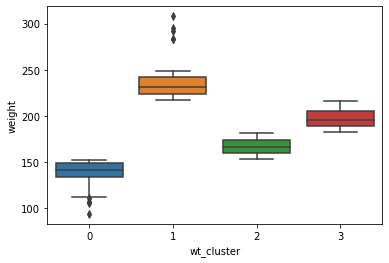

In [132]:
km = KMeans(n_clusters=4).fit(X[['weight']])
X['wt_cluster'] = km.labels_
sns.boxplot(y='weight', x='wt_cluster', data=X)

In [133]:
method = 'median'
X['bmi'] = X['bmi'].fillna(X.groupby('wt_cluster')['bmi'].transform(method))

In [134]:
X['blood_pressure'] = X['blood_pressure'].fillna(X.groupby('wt_cluster')['blood_pressure'].transform(method))

<AxesSubplot:xlabel='bmi_bp_cluster', ylabel='blood_pressure'>

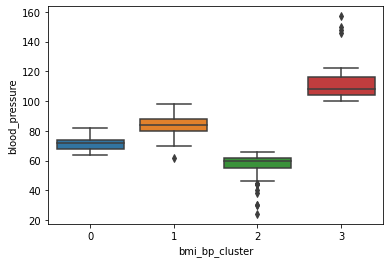

In [135]:
km = KMeans(n_clusters=4).fit(X[['bmi', 'blood_pressure']])
X['bmi_bp_cluster'] = km.labels_
sns.boxplot(y='blood_pressure', x='bmi_bp_cluster', data=X)

In [136]:
X['cardio_stress_test'] = X['cardio_stress_test'].fillna(X.groupby('bmi_bp_cluster')['cardio_stress_test'].transform(method))

<AxesSubplot:xlabel='cs_cluster', ylabel='cardio_stress_test'>

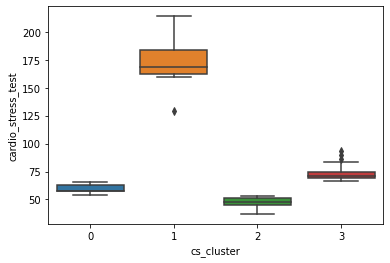

In [137]:
km = KMeans(n_clusters=4).fit(X[['cardio_stress_test']])
X['cs_cluster'] = km.labels_
sns.boxplot(y='cardio_stress_test', x='cs_cluster', data=X)

In [138]:
X['insulin_test'] = X['insulin_test'].fillna(X.groupby('cs_cluster')['insulin_test'].transform(method))

As we can see, the distribution of the factors - columns age, insulin_test, liver_stress_test and years_smoking are left skewed. So, I will take boxcox of them

In [139]:
X.sample(5)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,age_cluster,wt_cluster,bmi_bp_cluster,cs_cluster
255,28,245,30.9,70.0,135.0,0.3908,58.0,6,1,1,0,0
111,19,193,42.4,84.0,310.0,1.1388,53.0,1,1,3,1,2
748,78,184,25.9,74.0,60.0,0.5228,63.0,9,3,3,0,0
577,60,151,32.9,76.0,180.0,0.2338,78.0,10,3,0,0,3
724,31,237,33.9,50.0,392.0,0.8888,63.0,7,0,1,2,0


In [154]:
X.drop(columns=['age_cluster', 'wt_cluster', 'bmi_bp_cluster', 'cs_cluster'], inplace=True)

In [172]:
X['height'] = np.sqrt(X.weight/X.bmi)
X.drop('height', axis=1, inplace=True)

In [173]:
#X['bp_insuline'] = ( X.insulin_test - X.insulin_test.mean() ) * (X.blood_pressure - X.blood_pressure.mean())

In [174]:
#X['ins_liver'] = ( X.insulin_test - X.insulin_test.mean() ) * (X.liver_stress_test - X.liver_stress_test.mean())

In [175]:
y.value_counts()

0    521
1    279
Name: zeta_disease, dtype: int64

There are two strong correlations which can be seen
1. The Age is related with the number of years one has smoked. As the age increases a smoker's number of years also increases.
2. The Insulin test and the Cardio stress test are also correlated, although not very strongly.
---

In [176]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## 1.3. Doing the train test split and scaling the data

Time to do the train test split in the training test. As there are 800 cases, a 70:30 split will be appropriate

In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.2,\
                                                    random_state=10, stratify=y)
cols_X = X_train.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.columns = cols_X
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))
X_test_scaled.columns = cols_X

---

### Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(class_weight='balanced').fit(X_train_scaled, y_train)
log_model.score(X_test_scaled, y_test)

0.825

In [179]:
print (metrics.classification_report(y_test, log_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       104
           1       0.72      0.82      0.77        56

    accuracy                           0.82       160
   macro avg       0.81      0.82      0.81       160
weighted avg       0.83      0.82      0.83       160



### Extra Trees Classifier

In [157]:
from sklearn.ensemble import ExtraTreesClassifier
ext_model = ExtraTreesClassifier(class_weight='balanced')
ext_model.fit(X_train_scaled, y_train)
ext_model.score(X_test_scaled, y_test)

0.8125

### Random Forest

In [158]:
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(class_weight="balanced", random_state=42,
                                 max_depth=4, n_jobs=-1).\
            fit(X_train_scaled, y_train)
best_rf.score(X_test_scaled, y_test)

0.76875

In [159]:
print (metrics.classification_report (y_test, best_rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       104
           1       0.63      0.82      0.71        56

    accuracy                           0.77       160
   macro avg       0.76      0.78      0.76       160
weighted avg       0.80      0.77      0.77       160



### XG Boost

In [151]:
from xgboost import XGBClassifier
xg_model = XGBClassifier(scale_pos_weight =1).fit(X_train_scaled, y_train)
xg_model.score(X_test_scaled, y_test)

0.7625

In [152]:
from sklearn.ensemble import VotingClassifier
vot_model = VotingClassifier(estimators = [('lr', LogisticRegression(class_weight="balanced")), 
                              ('rf', RandomForestClassifier(class_weight="balanced", 
                                                            random_state=42, 
                                                            max_depth=4, 
                                                            n_jobs=-1)),
                              ('ext', ExtraTreesClassifier(class_weight="balanced")),
                              ('xg', XGBClassifier(scale_pos_weight =1) )],
                            voting = 'soft')
vot_model.fit(X_train_scaled, y_train)
vot_model.score(X_test_scaled, y_test)

0.74375

In [153]:
y_pred = vot_model.predict(X_test_scaled)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred ))

,0,1
0,80,24
1,17,39


In [210]:
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       150
           1       0.77      0.70      0.73        90

    accuracy                           0.81       240
   macro avg       0.80      0.79      0.79       240
weighted avg       0.81      0.81      0.81       240



D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


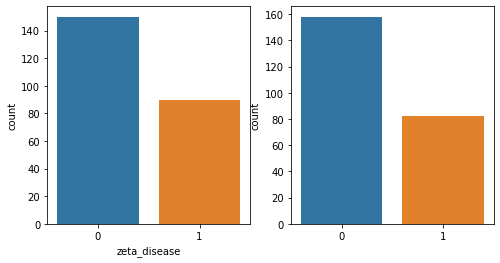

In [212]:
plt.figure(figsize=(8, 4) )
plt.subplot(121); sns.countplot(y_test)
plt.subplot(122); sns.countplot(y_pred)
plt.show()

Text(0, 0.5, 'Feature')

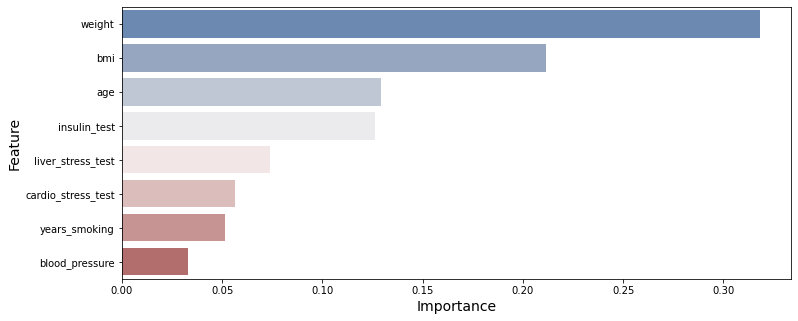

In [213]:
df_feature_importance = pd.DataFrame(columns=['Feature', 'Importance'])
df_feature_importance.Feature = X_train.columns
df_feature_importance.Importance = best_rf.feature_importances_
df_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=df_feature_importance, palette='vlag')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# 3. Conculsion from the model:

The metrics that has been used in the model building is **recall**. The problem statment says we need to make the correct prediction in the cases who will be infected from the disease. 

The forumla for recall is given as $\frac{True Positive}{True Positive + False Negative}$ and hence having a high recall value ensures that there are lease False Negatives. Hence the model will be able to catch more of the infection possibilities

The three risk factors which have the hightest impact are **weight**, **bmi** and the **age**. Hence people who have are older and have a higher weight and bmi should be more cautious in the International Mars Colony as they have the highest chances of zeta infection

---
# 4. Predicting from the Test data
---
## 4.1. Doing the same data transformations as done on the Training data set

In [235]:
df_test = pd.read_csv('2021-01-21_zeta-disease_prediction-data_dsi-take-home-challenge.csv')
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [237]:
# Applying boxcox on the skewed data 
for col in cols_skewed:
    new_col = col+'_boxcox'
    df_test[new_col] = stats.boxcox(df_test[col]+1)[0] #adding 1 for a workaround for zero.
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,24,151,39.5,69,72,1.3968,56,4,NaN,3.470650,4.195325,0.940059,0.345031,1.380107
1,27,179,35.5,89,156,1.6608,43,6,NaN,3.602503,4.924471,0.942594,0.354462,1.617554
2,34,147,26.9,76,74,1.6958,53,2,NaN,3.864148,4.221161,0.941100,0.355471,0.988286
3,35,206,32.4,73,127,1.4608,61,6,NaN,3.897372,4.730599,0.940679,0.347656,1.617554
4,60,193,29.8,62,192,1.7798,65,9,NaN,4.527369,5.120038,0.938781,0.357711,1.852717


In [238]:
df_test.drop(cols_skewed, axis=1, inplace=True)

In [239]:
df_test.head()

,weight,bmi,cardio_stress_test,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,NaN,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,NaN,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,NaN,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,NaN,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,NaN,4.527369,5.120038,0.938781,0.357711,1.852717


In [240]:
X_asked = df_test.drop('zeta_disease', axis=1)
X_asked.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,4.527369,5.120038,0.938781,0.357711,1.852717


In [242]:
X_asked_scaled = pd.DataFrame(scaler.transform(X_asked))
X_asked_scaled.columns = cols_X
X_asked_scaled.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,-0.670609,0.854230,0.423769,274.508809,0.606986,-2.914722,1.420138,-0.041663
1,0.206516,0.386054,-0.003990,288.671656,0.895515,-2.914695,1.562466,0.232610
2,-0.795913,-0.620522,0.325056,316.775999,0.617209,-2.914711,1.577697,-0.494253
3,1.052315,0.023219,0.588292,320.344698,0.818798,-2.914715,1.459755,0.232610
4,0.645079,-0.281095,0.719910,388.015103,0.972902,-2.914735,1.611491,0.504246


In [294]:
df_test.zeta_disease = best_model.predict(X_asked_scaled)

# 4.2. The final test data sets, along with the predictions

In [295]:
df_test

,weight,bmi,cardio_stress_test,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,0,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,1,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,0,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,1,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,1,4.527369,5.120038,0.938781,0.357711,1.852717
5,120,36.5,54,0,4.188295,3.851832,0.944122,0.340436,2.015493
6,139,38.2,68,0,3.269141,4.258637,0.938574,0.351999,1.213767
7,137,31.2,59,0,3.423324,4.208331,0.940221,0.345878,1.707526
8,195,30.5,59,1,3.929727,4.829191,0.938139,0.347223,1.617554
9,193,25.8,50,0,3.213042,4.113297,0.942075,0.358061,1.213767
